# MNIST detection with RCNN

In [1]:
from matplotlib import patches
from matplotlib import pyplot as plt
from tensorflow.keras import datasets
from tqdm import tqdm

# %pip install opencv-contrib-python

import cv2
import numpy as np
import tensorflow as tf

In [2]:
%run ../src/core.py
%run ../src/layers.py
%run ../src/loss.py
%run ../src/network.py
%run ../src/metrics.py

## Data preparation

In [3]:
# Download MNIST dataset
(
    mnist_train_images,
    mnist_train_labels,
), (
    mnist_test_images,
    mnist_test_labels,
) = datasets.mnist.load_data()

mnist_images = np.concatenate([mnist_train_images, mnist_test_images])
mnist_labels = np.concatenate([mnist_train_labels, mnist_test_labels])

# Normalize images
mnist_images = mnist_images.astype(np.float32) / 255.0
mnist_images = mnist_images[..., np.newaxis]

## Dataset preparation

In [4]:
TARGET_SIZE = (128, 128)

In [5]:
# Create a object detection dataset
def generate_mnist_detection_dataset(
    images: np.ndarray,
    object_size: tuple,
    labels: np.ndarray,
    samples: int,
    target_size: tuple,
    min_objects_per_image: int = 1,
    max_objects_per_image: int = 5,
    seed=42,
):
    np.random.seed(seed)

    x = []
    y = []

    for i in tqdm(range(samples)):
        bg_image = np.zeros(target_size + (3,), dtype=np.float32)

        # Sample a random number of objects to place on the background image
        num_objs = np.random.randint(min_objects_per_image, max_objects_per_image + 1)

        # Sample random objects from the dataset
        obj_idxs = np.random.randint(0, len(images), num_objs)
        obj_images = images[obj_idxs]
        obj_labels = labels[obj_idxs]

        # Sample random positions to place the objects on the background image
        pos_xs = np.random.randint(0, target_size[1] - object_size[1], num_objs)
        pos_ys = np.random.randint(0, target_size[0] - object_size[0], num_objs)
        positions = np.stack([pos_xs, pos_ys], axis=1)

        # Avoid overlapping objects
        attempts_left = 100
        while attempts_left > 0:
            all_good = True
            for i in range(positions.shape[0]):
                x1, y1 = positions[i]
                x2, y2 = x1 + object_size[1], y1 + object_size[0]

                for j in range(i + 1, positions.shape[0]):
                    x3, y3 = positions[j]
                    x4, y4 = x3 + object_size[1], y3 + object_size[0]

                    if x2 >= x3 and x4 >= x1 and y2 >= y3 and y4 >= y1:
                        all_good = False
                        positions[j] = np.array(
                            [
                                np.random.randint(
                                    0, bg_image.shape[1] - object_size[1]
                                ),
                                np.random.randint(
                                    0, bg_image.shape[0] - object_size[0]
                                ),
                            ]
                        )

            attempts_left -= 1
            if all_good:
                break

        _y = []

        # Paste the objects on the background image
        for obj_image, obj_label, position in zip(obj_images, obj_labels, positions):
            x1, y1 = position
            x2, y2 = x1 + object_size[1], y1 + object_size[0]

            # Paste the object on the background image
            bg_image[y1:y2, x1:x2, :] = obj_image

            # Compute the bounding box coordinates
            x1, y1 = x1 / bg_image.shape[1], y1 / bg_image.shape[0]
            x2, y2 = x2 / bg_image.shape[1], y2 / bg_image.shape[0]

            # Append the bounding box coordinates and the class label
            _y.append([obj_label, x1, y1, x2, y2])

        x.append(bg_image)
        y.append(_y)

    return x, y

In [6]:
mnist_detection_images, mnist_detection_annotations = generate_mnist_detection_dataset(
    mnist_images,
    object_size=(28, 28),
    labels=mnist_labels,
    samples=5000,
    target_size=TARGET_SIZE,
)

# Separate labels and bounding boxes
mnist_detection_labels = []
mnist_detection_boxes = []

for annotations in mnist_detection_annotations:
    labels = []
    boxes = []

    for annotation in annotations:
        label, x1, y1, x2, y2 = annotation

        labels.append(label)
        boxes.append([x1, y1, x2, y2])

    mnist_detection_labels.append(labels)
    mnist_detection_boxes.append(boxes)

100%|██████████| 5000/5000 [00:01<00:00, 3803.79it/s]


In [7]:
def sample_random_20(images: list, labels: list = None):
    idxs = np.random.randint(0, len(images), 20)

    _, axes = plt.subplots(4, 5, figsize=(15, 10))
    for i, idx in enumerate(idxs):
        ax = axes[i // 5, i % 5]
        if labels is not None:
            ax.set_title(labels[idx])
        ax.imshow(images[idx])

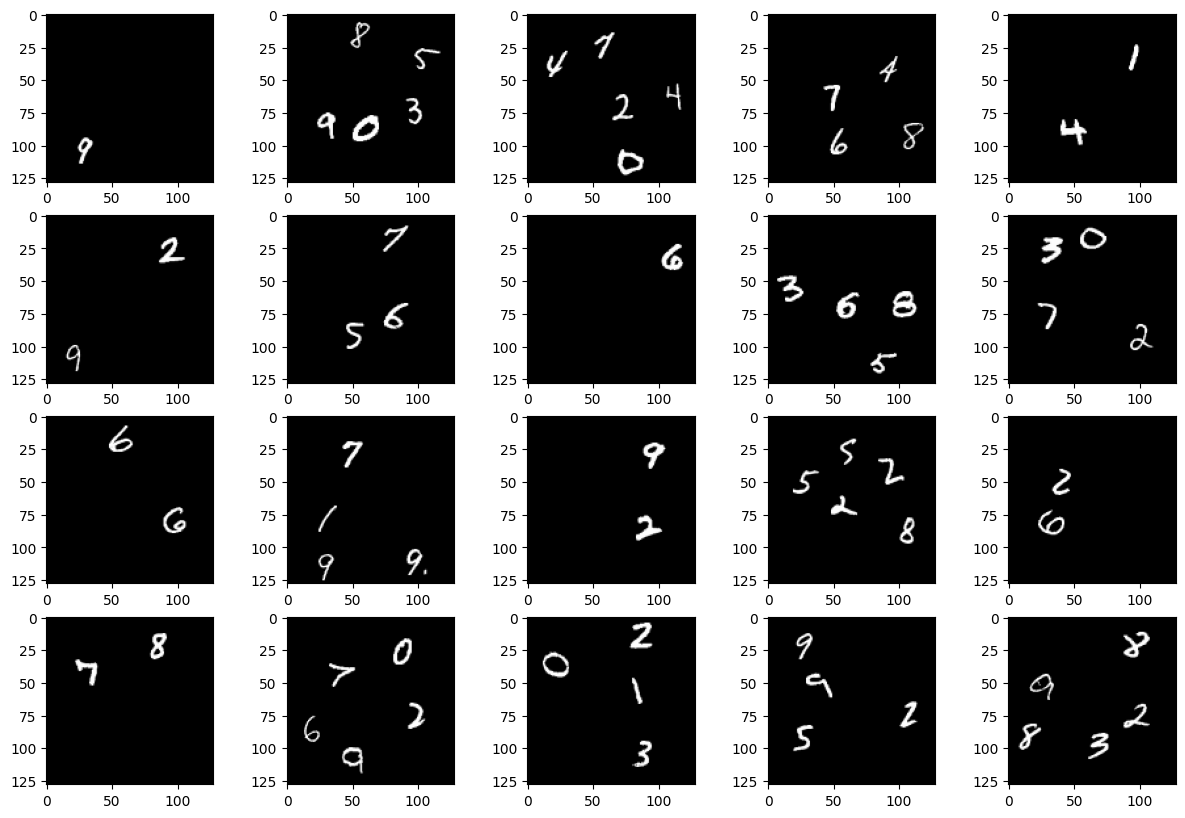

In [8]:
# Sample and plot 20 random background images
sample_random_20(mnist_detection_images)

## Methods implementation

In [9]:
def selective_search(image: np.ndarray) -> list:
    """
    Source: https://www.kaggle.com/code/ritvik1909/object-detection-selective-search
    """
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()

    rects = ss.process()
    x_min, y_min, w, h = tf.unstack(rects, axis=1)

    rects = tf.stack([x_min, y_min, x_min + w, y_min + h], axis=1)
    return rects.numpy().tolist()


def plot_image_regions(img: np.ndarray, rects: list, normalized: bool):
    _, ax = plt.subplots()
    ax.imshow(img)

    for x_min, y_min, x_max, y_max in rects:
        if normalized:
            x_min *= img.shape[1]
            y_min *= img.shape[0]
            x_max *= img.shape[1]
            y_max *= img.shape[0]

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.show()

In [10]:
def extract_region(img: np.ndarray, bbox: list[float], normalized: bool = True):
    x1, y1, x2, y2 = bbox
    if normalized:
        x1 *= img.shape[1]
        y1 *= img.shape[0]
        x2 *= img.shape[1]
        y2 *= img.shape[0]

    return img[int(y1) : int(y2), int(x1) : int(x2)]


def extract_background_region(
    img: np.ndarray,
    regions: list[list[float]],
    normalized: bool = True,
    min_size: tuple = (28, 28),
    max_size: tuple = (64, 64),
    max_attempts: int = 10,
):
    for _ in range(max_attempts):
        size = (
            np.random.randint(min_size[0], max_size[0]),
            np.random.randint(min_size[1], max_size[1]),
        )

        x1 = np.random.randint(0, img.shape[1] - size[0] - 1)
        y1 = np.random.randint(0, img.shape[0] - size[1] - 1)
        x2 = x1 + size[0]
        y2 = y1 + size[1]

        if normalized:
            x1 /= img.shape[1]
            y1 /= img.shape[0]
            x2 /= img.shape[1]
            y2 /= img.shape[0]

        bbox = [x1, y1, x2, y2]
        if not any([jaccard_coefficient(bbox, region) > 0.95 for region in regions]):
            return extract_region(img, bbox, normalized=normalized)

    return None

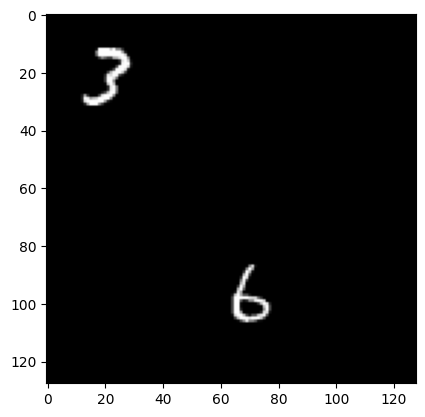

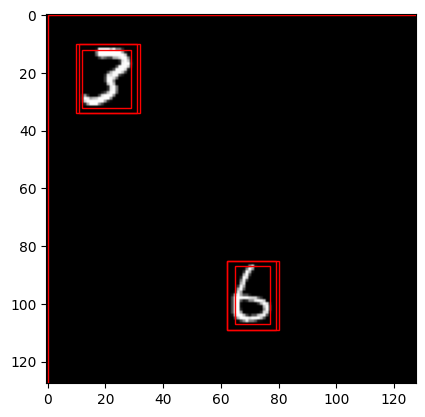

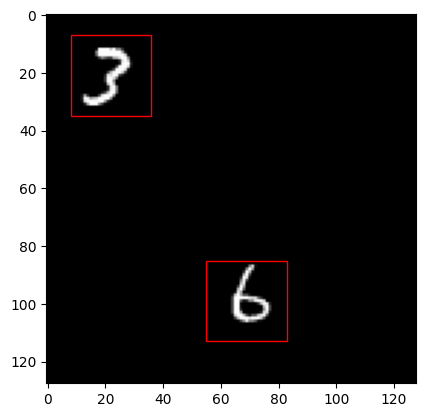

In [11]:
idx = np.random.randint(0, len(mnist_detection_images))
img = mnist_detection_images[idx]
regions = mnist_detection_boxes[idx]

# Plot the image
plt.imshow(img)

# Plot the proposed regions
proposed_regions = selective_search(img)
plot_image_regions(img, proposed_regions, normalized=False)

# Plot the ground truth bounding boxes
plot_image_regions(img, regions, normalized=True)

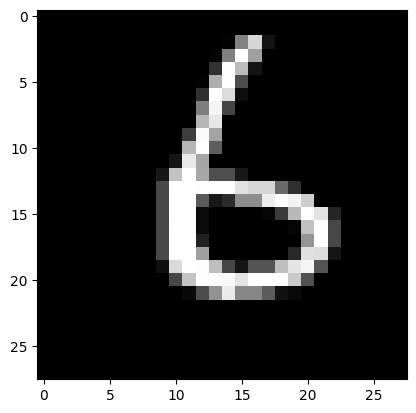

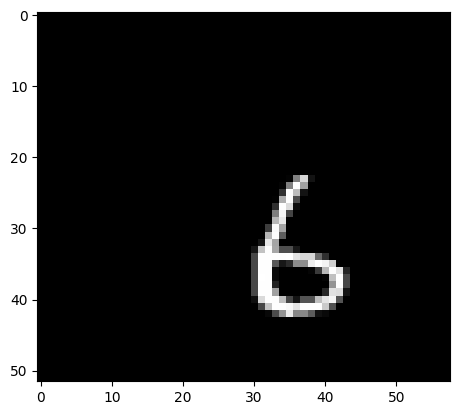

In [12]:
# Extract a region
region = extract_region(img, regions[0])
plt.imshow(region)
plt.show()

# Extract a background region
background_region = extract_background_region(img, regions)
plt.imshow(background_region)
plt.show()

## Preparing classification dataset


In [13]:
def generate_mnist_classification_dataset(
    images,
    annotations,
    classes,
    classes_encoding,
    background_regions_frac: float = 1,
    target_size=(28, 28),
):
    classification_images = []
    classification_labels = []

    back_id = len(classes_encoding)
    class_count = np.zeros(len(classes_encoding) + 1, dtype=np.int32)

    for img, _annotations, _classes in tqdm(
        zip(images, annotations, classes),
        desc="Generating classification dataset",
        total=len(images),
    ):
        for bbox, label in zip(_annotations, _classes):
            region = extract_region(img, bbox, normalized=True)
            region = cv2.resize(region, target_size)

            # Do some shift augmentation
            shift = np.random.randint(-5, 5)
            region = np.roll(region, shift, axis=0)
            shift = np.random.randint(-5, 5)
            region = np.roll(region, shift, axis=1)

            classification_images.append(region)
            classification_labels.append(label)

            class_count[label] += 1

        # Generate background regions
        while class_count[back_id] < min(class_count[:-1]) * background_regions_frac:
            # Train that image with some artifacts is empty too
            if np.random.random() > 0.5:
                region = cv2.resize(img, target_size)
            else:
                region = extract_background_region(img, _annotations, normalized=True)
                if region is None:
                    break
                region = cv2.resize(region, target_size)

            classification_images.append(region)
            classification_labels.append(back_id)

            class_count[back_id] += 1

    classification_images = np.array(classification_images)

    # Plot class distribution
    unique, counts = np.unique(classification_labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique)
    plt.show()

    return classification_images, classification_labels, back_id

Generating classification dataset: 100%|██████████| 5000/5000 [00:00<00:00, 10230.01it/s]


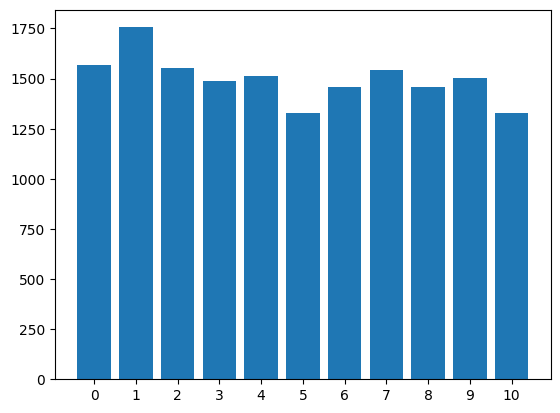

In [14]:
(
    classification_images,
    classification_labels,
    back_id,
) = generate_mnist_classification_dataset(
    mnist_detection_images,
    mnist_detection_boxes,
    mnist_detection_labels,
    classes_encoding={i: i for i in range(10)},
    background_regions_frac=1,
    target_size=(28, 28),
)

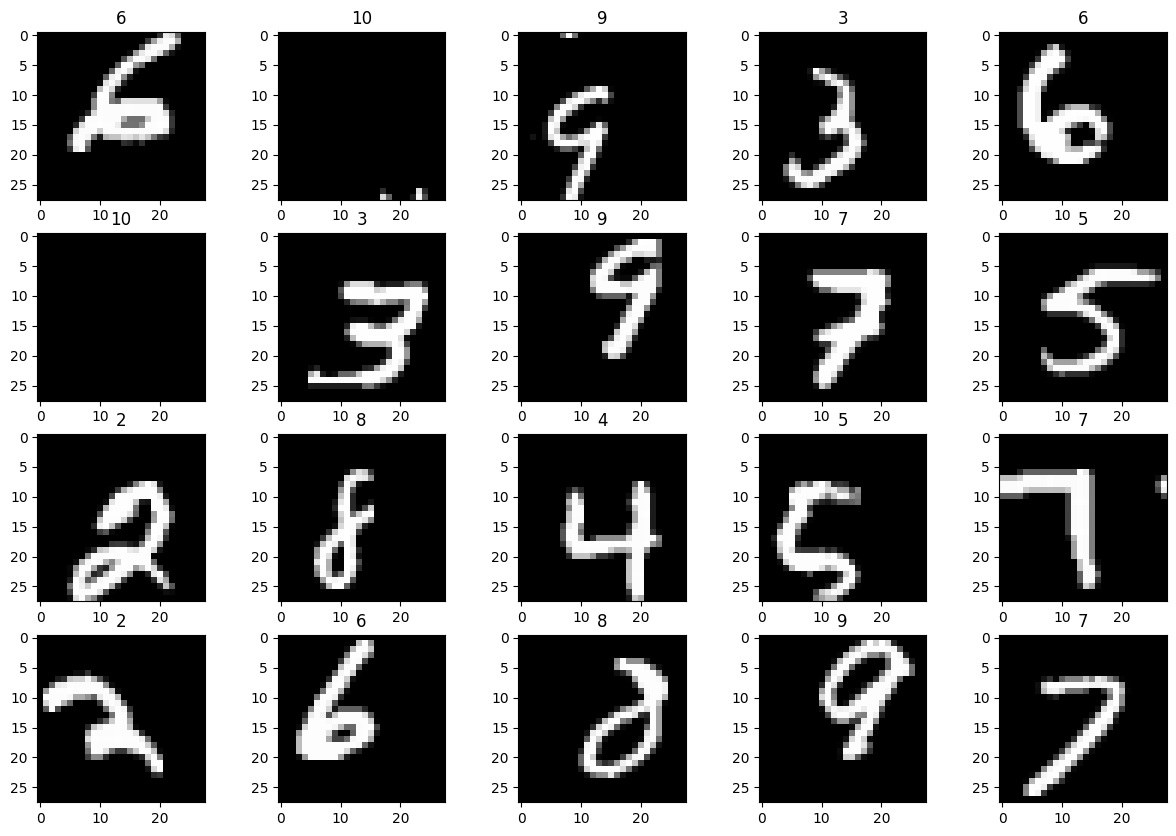

In [15]:
sample_random_20(classification_images, classification_labels)

# Prepare for training

In [16]:
# Reshape the images to (B, C, H, W)
classification_images_reshaped = classification_images.transpose(0, 3, 1, 2)[
    :, None, ...
]
classification_images_reshaped.shape

(16497, 1, 3, 28, 28)

In [17]:
# One-hot encode labels
classification_labels_ohe = np.eye(len(np.unique(classification_labels)))[
    classification_labels
][..., None]
classification_labels_ohe.shape

(16497, 11, 1)

In [18]:
from collections import defaultdict

In [19]:
class RCNN(Network):
    def __init__(self, in_channels: int, num_classes: int):
        self.num_classes = num_classes
        super().__init__(
            [
                Conv2d(in_channels, num_filters=1, kernel_size=3, padding=1),  # 28x28
                ReLU(),
                Conv2d(1, num_filters=1, kernel_size=5, padding=2),  # 28x28
                ReLU(),
                Conv2d(1, num_filters=1, kernel_size=9, padding=4),  # 28x28
                ReLU(),
                Flatten((1, 1, 28, 28)),
                Linear(28**2, 100),
                ReLU(),
                Linear(100, num_classes),
                Softmax(),
            ],
            CrossEntropy(),
            argmax_equal,
        )

    def evaluate(self, x: np.ndarray, y: np.ndarray) -> float:
        per_class_count = defaultdict(int)
        per_class_correct = defaultdict(int)

        for i in range(len(x)):
            out = self.forward(x[i])
            metric = self.metric(out, y[i])

            per_class_count[np.argmax(y[i])] += 1
            per_class_correct[np.argmax(y[i])] += metric

        # Calculate the accuracy per class
        result = np.array(
            [
                per_class_correct[k] / (per_class_count[k] + 1)
                for k in range(self.num_classes)
            ]
        )
        print(result)
        return np.mean(result)

## Model and training

In [20]:
np.random.seed(42)

model = RCNN(3, 11)
model.train(
    classification_images_reshaped,
    classification_labels_ohe,
    epochs=15,
    lr=0.001,
    shuffle=True,
)

Epoch 1/15


100%|██████████| 13215/13215 [00:16<00:00, 793.88it/s, loss=2.36]


Evaluating... [0.74425287 0.5407855  0.26578073 0.12080537 0.20588235 0.0167364
 0.4952381  0.20061728 0.17182131 0.08305648 0.28033473]
Validation score: 28.41192%
Epoch 2/15


100%|██████████| 13269/13269 [00:17<00:00, 778.32it/s, loss=1.5] 


Evaluating... [0.85488959 0.93957704 0.57706093 0.3442623  0.54037267 0.5502008
 0.69520548 0.64784053 0.68888889 0.43006993 0.64808362]
Validation score: 62.87683%
Epoch 3/15


100%|██████████| 13088/13088 [00:16<00:00, 815.60it/s, loss=0.917]


Evaluating... [0.90566038 0.94647887 0.7523511  0.57728707 0.81424149 0.6875
 0.82295082 0.75548589 0.75601375 0.41914191 0.75167785]
Validation score: 74.44354%
Epoch 4/15


100%|██████████| 13108/13108 [00:15<00:00, 828.74it/s, loss=0.684]


Evaluating... [0.93396226 0.94010417 0.84935897 0.71339564 0.84545455 0.71102662
 0.74038462 0.8419244  0.85365854 0.47278912 0.79861111]
Validation score: 79.09700%
Epoch 5/15


100%|██████████| 13264/13264 [00:16<00:00, 818.45it/s, loss=0.541]


Evaluating... [0.93059937 0.92537313 0.83221477 0.81184669 0.86296296 0.74087591
 0.84027778 0.86348123 0.81605351 0.5875     0.80228137]
Validation score: 81.94061%
Epoch 6/15


100%|██████████| 13182/13182 [00:20<00:00, 642.01it/s, loss=0.466]


Evaluating... [0.94557823 0.9558011  0.85669782 0.89642857 0.87581699 0.70462633
 0.86594203 0.87820513 0.84516129 0.72516556 0.82978723]
Validation score: 85.26555%
Epoch 7/15


100%|██████████| 13270/13270 [00:19<00:00, 687.64it/s, loss=0.403]


Evaluating... [0.96539792 0.96774194 0.83552632 0.86006826 0.87179487 0.84775087
 0.87591241 0.90938511 0.87030717 0.73076923 0.85440613]
Validation score: 87.17327%
Epoch 8/15


100%|██████████| 13164/13164 [00:18<00:00, 711.96it/s, loss=0.358]


Evaluating... [0.97546012 0.97947214 0.88853503 0.87579618 0.90522876 0.85
 0.88039867 0.90127389 0.8556701  0.75496689 0.90181818]
Validation score: 88.80564%
Epoch 9/15


100%|██████████| 13129/13129 [00:17<00:00, 731.29it/s, loss=0.32] 


Evaluating... [0.98376623 0.96542553 0.89520958 0.87457627 0.92331288 0.81060606
 0.82307692 0.91167192 0.9118541  0.79801325 0.85447761]
Validation score: 88.65446%
Epoch 10/15


100%|██████████| 13195/13195 [00:19<00:00, 668.99it/s, loss=0.287] 


Evaluating... [0.97115385 0.95468278 0.92705167 0.90747331 0.92038217 0.85616438
 0.83972125 0.92332268 0.91724138 0.78175896 0.88715953]
Validation score: 89.87375%
Epoch 11/15


100%|██████████| 13205/13205 [00:18<00:00, 698.60it/s, loss=0.258]


Evaluating... [0.95081967 0.97245179 0.89349112 0.91749175 0.9379085  0.86530612
 0.88996764 0.91666667 0.89513109 0.81699346 0.84444444]
Validation score: 90.00611%
Epoch 12/15


100%|██████████| 13183/13183 [00:19<00:00, 690.54it/s, loss=0.229]


Evaluating... [0.96666667 0.96327684 0.92380952 0.88275862 0.94174757 0.85663082
 0.86296296 0.93225806 0.9295302  0.80654762 0.82954545]
Validation score: 89.96122%
Epoch 13/15


100%|██████████| 13225/13225 [00:19<00:00, 672.13it/s, loss=0.209]


Evaluating... [0.96374622 0.96656535 0.91608392 0.90974729 0.94754098 0.84313725
 0.86971831 0.8969697  0.91467577 0.83742331 0.90636704]
Validation score: 90.65432%
Epoch 14/15


100%|██████████| 13265/13265 [00:18<00:00, 736.01it/s, loss=0.186]


Evaluating... [0.96232877 0.9761194  0.94871795 0.93478261 0.94463668 0.87588652
 0.85483871 0.92207792 0.88321168 0.87378641 0.921875  ]
Validation score: 91.80238%
Epoch 15/15


100%|██████████| 13221/13221 [00:18<00:00, 703.16it/s, loss=0.172]


Evaluating... [0.95555556 0.96610169 0.91111111 0.92068966 0.91366906 0.84824903
 0.87719298 0.96271186 0.9147541  0.84615385 0.936     ]
Validation score: 91.38354%


In [21]:
def resize_aspect_ratio_padding(img: np.ndarray, target_size: tuple) -> np.ndarray:
    hh, ww = img.shape[:2]

    if hh > ww:
        new_hh = target_size[0]
        new_ww = int(ww * (new_hh / hh))
    else:
        new_ww = target_size[1]
        new_hh = int(hh * (new_ww / ww))

    img = cv2.resize(img, (new_ww, new_hh))

    top = (target_size[0] - new_hh) // 2
    bottom = target_size[0] - new_hh - top
    left = (target_size[1] - new_ww) // 2
    right = target_size[1] - new_ww - left

    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, 0)

    return img

## Testing the model

In [22]:
def rcnn_predict(model: RCNN, img: np.ndarray):
    proposed_regions = selective_search(img)
    proposed_regions_labels = []
    proposed_regions_labels_confidence = []

    for region in proposed_regions:
        region = extract_region(img, region, normalized=False)
        region = resize_aspect_ratio_padding(region, (28, 28))

        region = region.transpose(2, 0, 1)[None, ...]

        out = model.forward(region)
        pred = np.argmax(out)

        if out[pred] < 0.5:
            pred = back_id
            out[pred] = 0

        proposed_regions_labels.append(pred)
        proposed_regions_labels_confidence.append(out[pred].squeeze())

    return proposed_regions, proposed_regions_labels, proposed_regions_labels_confidence

In [23]:
def filter_proposals(proposed_regions, regions_labels, labels_confidence):
    iou_matrix = np.zeros((len(proposed_regions), len(proposed_regions)))

    for i in range(len(proposed_regions)):
        for j in range(len(proposed_regions)):
            iou_matrix[i, j] = jaccard_coefficient(
                proposed_regions[i], proposed_regions[j]
            )

    group_indices = []

    # Put regions with high IoU in the same group
    for i in range(len(proposed_regions)):
        if i not in group_indices:
            group_indices.append([i])

        for j in range(len(proposed_regions)):
            if i != j and iou_matrix[i, j] >= 0.5:
                group_indices[-1].append(j)

    # Assign a number to each group if it's unique
    group_labels = np.zeros(len(proposed_regions), dtype=np.int32)

    for i, group in enumerate(group_indices):
        if len(group) == 1:
            group_labels[group[0]] = i
        else:
            group_labels[group] = i

    group_labels_confidence = np.zeros(len(proposed_regions), dtype=np.float32)

    # Gather the labels and confidence for each group
    for i, group in enumerate(group_indices):
        filtered_labels = defaultdict(int)
        for idx in group:
            filtered_labels[regions_labels[idx]] += labels_confidence[idx]

        # Pick a label with the highest sum of confidence
        group_labels_confidence[i] = max(filtered_labels, key=filtered_labels.get)

    filtered_regions = []
    filtered_labels = []

    visited = set()

    # Filter out the regions with the same label
    for idx, group, conf in zip(group_labels, group_indices, group_labels_confidence):
        if idx not in visited:
            visited.add(idx)
            filtered_regions.append(proposed_regions[group[0]])
            filtered_labels.append(conf)

    return filtered_regions, filtered_labels

## Inference

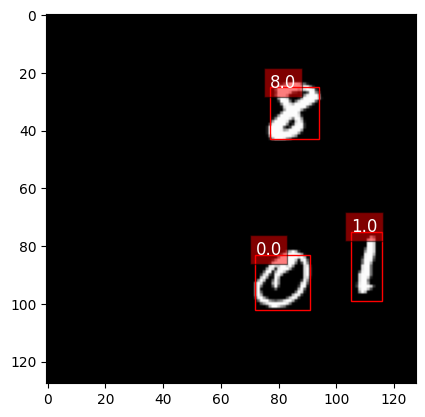

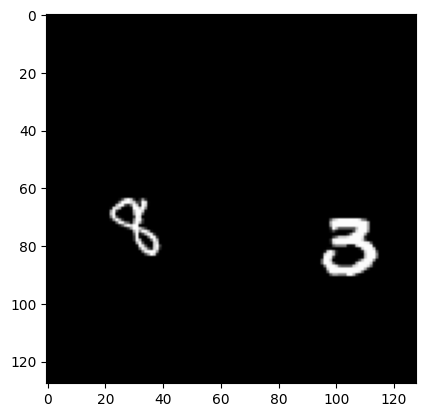

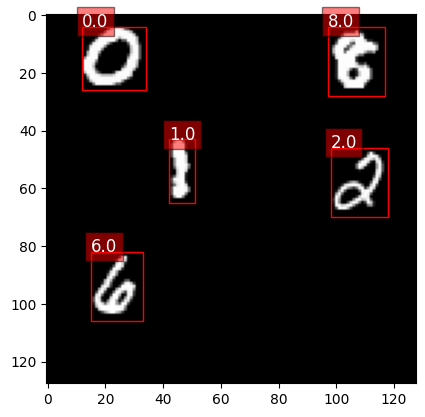

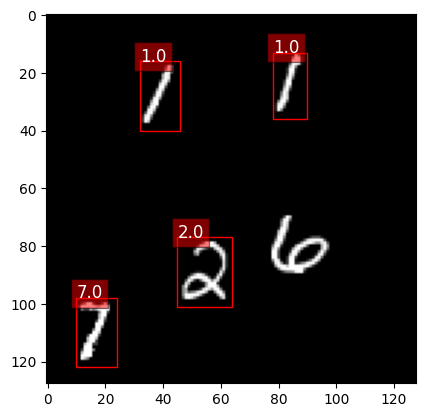

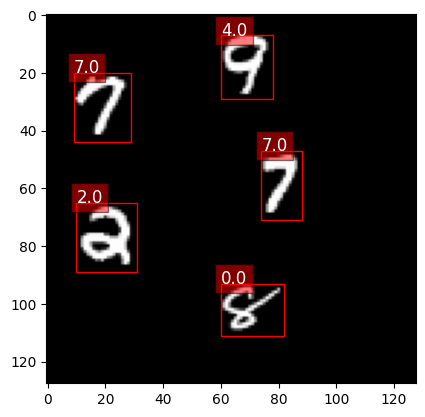

In [32]:
for _ in range(5):
    test_idx = np.random.randint(0, len(mnist_detection_images))
    test_img = mnist_detection_images[test_idx]

    # Plot the image
    plt.imshow(test_img)

    for region, label in zip(*filter_proposals(*rcnn_predict(model, test_img))):
        if label == back_id:
            continue

        x_min, y_min, x_max, y_max = region
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        plt.text(
            x_min,
            y_min,
            f"{label}",
            bbox=dict(facecolor="red", alpha=0.5),
            fontsize=12,
            color="white",
        )
        ax = plt.gca()
        ax.add_patch(rect)
    plt.show()

## Evaluation

In [25]:
test_images, test_annotations = generate_mnist_detection_dataset(
    mnist_images,
    object_size=(28, 28),
    labels=mnist_labels,
    samples=1000,
    target_size=TARGET_SIZE,
)

# Separate labels and bounding boxes
test_labels = []
test_boxes = []

for annotations in test_annotations:
    labels = []
    boxes = []

    for annotation in annotations:
        label, x1, y1, x2, y2 = annotation

        labels.append(label)
        boxes.append([x1, y1, x2, y2])

    test_labels.append(labels)
    test_boxes.append(boxes)

100%|██████████| 1000/1000 [00:00<00:00, 6767.17it/s]


In [26]:
true_positives = 0
false_positives = 0
false_negatives = 0

for img, annotations, labels in tqdm(
    zip(test_images, test_boxes, test_labels), total=len(test_images)
):
    filtered_regions, filtered_labels = filter_proposals(*rcnn_predict(model, img))

    # Normalize the regions
    for i in range(len(filtered_regions)):
        x1, y1, x2, y2 = filtered_regions[i]
        filtered_regions[i] = [
            x1 / img.shape[1],
            y1 / img.shape[0],
            x2 / img.shape[1],
            y2 / img.shape[0],
        ]

    for region, label in zip(filtered_regions, filtered_labels):
        if label == back_id:
            continue

        for annotation, label in zip(annotations, labels):
            if jaccard_coefficient(region, annotation) > 0.5 and label == label:
                true_positives += 1
                break
        else:
            false_positives += 1

    for annotation in annotations:
        for region in filtered_regions:
            if jaccard_coefficient(region, annotation) > 0.5:
                break
        else:
            false_negatives += 1

100%|██████████| 1000/1000 [00:55<00:00, 18.05it/s]


In [27]:
print(f"Precission: {true_positives / (true_positives + false_positives)}")
print(f"Recall: {true_positives / (true_positives + false_negatives)}")

Precission: 0.5462417734672671
Recall: 0.5588235294117647
